In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from HelperFunctions import timestmphm2sec

In [2]:
path = "/home/helge/Applications/matsim/matsim_results/4DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_diag_30min/200/ITERS/it.0/"
path = "/home/helge/Applications/matsim/matsim_results_ssd/NonPeriodicBC/8DrtCap/OwnIntermodalAccEgr/OptDrtCount/WithServability/oneDrtFleet/bim_15min_diag/200/ITERS/it.0/"
# path = "/home/helge/Applications/matsim/matsim_results_ssd/PeriodicBC/8DrtCap/OwnIntermodalAccEgr/SteffenDrt/drt300/ITERS/it.0/"
pathDetour = path + "0.drt_detours_drt.csv"
pathTrips = path + "0.drt_trips_drt.csv"
pathOccs = path + "0.drt_occupancy_time_profiles_drt.txt"
detour_df = pd.read_csv(pathDetour, delimiter=";")
trip_df = pd.read_csv(pathTrips, delimiter=";")
occ_df = pd.read_csv(pathOccs, delimiter="\t")
occ_df["time"] = occ_df["time"].apply(timestmphm2sec)

10.8732523278235
1.7181448437604332


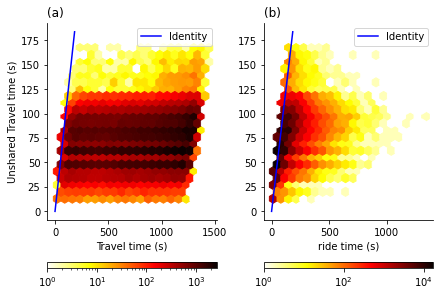

In [3]:
%matplotlib inline
from matplotlib.colors import LogNorm
plt.ion()

fig, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True)
# fig = plt.figure(constrained_layout=True)
# gs = fig.add_gridspec(12, 2)
# ax = fig.add_subplot(gs[:10, 0])
# ax2 = fig.add_subplot(gs[:10, 1])
# cax = fig.add_subplot(gs[11,0])
# cax2 = fig.add_subplot(gs[11,1])

xmin = detour_df["time"].min()
xmax = detour_df["time"].max()
ymin = detour_df["unsharedTime"].min()
ymax = detour_df["unsharedTime"].max()
nx, ny = int((xmax - xmin) / 50), int((ymax - ymin) / 50)
# im = ax.hexbin(detour_df["time"], detour_df["unsharedTime"], gridsize=(nx, ny), cmap='hot_r', extent=(xmin,xmax,ymin,ymax))
im = ax.hexbin(
    detour_df["time"],
    detour_df["unsharedTime"],
    gridsize=20,
    cmap="hot_r",
    extent=(xmin, xmax, ymin, ymax),
    norm=LogNorm(),
)
# ax.plot([-100, xlim[1]], [-100, xlim[1]], c="r", label='Identity')
# ax.scatter(detour_df["time"], detour_df["unsharedTime"], alpha=0.5, s=1, label='Data')
ax.plot([0, ymax * 1.1], [0, ymax * 1.1], c="b", label="Identity")
print(detour_df["time"].mean()/detour_df["unsharedTime"].mean())

ax.set_xlabel("Travel time (s)")
ax.set_ylabel("Unshared Travel time (s)")
ax.set_title("(a)", loc="left")
# fig.colorbar(im, cax=cax, orientation='horizontal')
fig.colorbar(im, ax=ax, location="bottom")
ax.legend()

ride_time = detour_df["time"] - trip_df["waitTime"]
xmin = ride_time.min()
xmax = ride_time.max()
ymin = detour_df["unsharedTime"].min()
ymax = detour_df["unsharedTime"].max()
# print(xmin, xmax, ymin, ymax)
nx, ny = int((xmax - xmin) / 50), int((ymax - ymin) / 10)
im2 = ax2.hexbin(
    ride_time,
    detour_df["unsharedTime"],
    #     gridsize=(nx, ny),
    gridsize=20,
    cmap="hot_r",
    norm=LogNorm(),
    #     extent=(xmin, xmax, ymin, ymax),
)
print(ride_time.mean()/detour_df["unsharedTime"].mean())
# ax2.scatter(ride_time, detour_df["unsharedTime"], s=0.01, label='data')
# xlim = ax2.get_xlim()
# ax2.plot([-100, xlim[1]], [-100, xlim[1]], c="r", label="Identity")
ax2.plot([0, ymax * 1.1], [0, ymax * 1.1], c="b", label="Identity")
ax2.set_xlabel("ride time (s)")
ax2.set_title("(b)", loc="left")
fig.colorbar(im2, ax=ax2, location="bottom")
# ax2.set_ylabel('Unshared ride time (s)')
ax2.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# fig.savefig('TimeDetourComparison.pdf')
plt.show()

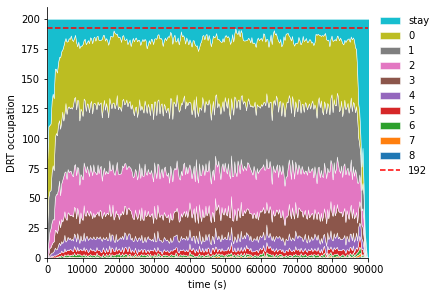

In [4]:
fig, ax = plt.subplots(constrained_layout=True)

labels_w_stay = occ_df.columns.drop("time").to_numpy()[::-1]
labels_wo_stay = [
    item[0] if item != "STAY" else "stay"
    for item in labels_w_stay
]
stack = ax.stackplot(
    occ_df["time"],
    #     occ_df[["4 pax", "3 pax", "2 pax", "1 pax", "0 pax", "STAY"]].T,
    occ_df[labels_w_stay].T,
    labels=labels_wo_stay,
    #     colors=["b", "g", "r", "c", "m", "grey"],
    linewidth=0.5,
    edgecolor="white",
)

max_needed_fleet_size = round(occ_df.drop(columns=["time", "STAY"]).sum(axis=1).max())

ax.axhline(max_needed_fleet_size, ls="--", c="r", label=max_needed_fleet_size)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1],
    labels=labels[::-1],
    bbox_to_anchor=(1.01, 0, 0.1, 1),
    loc="upper left",
    ncol=1,
    frameon=False
)

ax.set_xlim((0, 25 * 60 * 60))  # occ_df['time'].max()))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("time (s)")
ax.set_ylabel("DRT occupation")

# fig.savefig("DrtOccupancy.pdf")

plt.show()

1.8613266069346817 0.7498534786813078


<IPython.core.display.Javascript object>


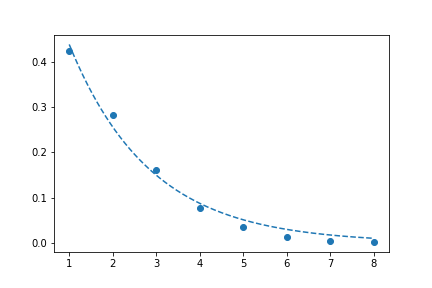

In [8]:
%matplotlib notebook

from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.integrate import quad

mask = (occ_df['time'] > 10000) & (occ_df['time'] < 85000)

mean_equil_occs = occ_df[mask].mean(axis=0).drop(['time','STAY'])
def boltzmann(E, kt, Z):
#     kt=1
    return Z*np.exp(-E/kt)
# display(mean_equil_occs)

#mean_equil_occs.plot(kind='scatter')
occupancies = np.arange(1,9)
occupancies_cont = np.linspace(occupancies[0], occupancies[-1], 1000)
probs = mean_equil_occs[1:]/np.sum(mean_equil_occs[1:])

popt, pcov = curve_fit(boltzmann, occupancies, probs)
# sol = least_squares(lambda kt: (boltzmann(occupancies, kt)-probs)**2, popt, verbose=1)
# print(sol)
print(*popt)
# popt[0] = 1.6

plt.scatter(occupancies, probs)
# plt.figure()
# Z,_ = quad(lambda x: boltzmann(x,*popt), 1,8) 

# plt.plot(occupancies, boltzmann(occupancies, *popt)/np.sum(boltzmann(occupancies, *popt)))
plt.plot(occupancies_cont, boltzmann(occupancies_cont, *popt), ls='--')

plt.show()